## 3D Seed Phenotyping with Pixelflow Demo
##### This notebook demonstrates how to use pixelflow to extract measurements of segmented objects from 3D imagery. This demo will use 3D lightbox images of Oilseed rape (Brassica napus) seedpods detected and segmented using an adapted StarDist model as described in [Corcoran et al. 2023](https://www.frontiersin.org/articles/10.3389/fpls.2023.1120182/full).

### 1. Install and load relevant packages

In [1]:
!pip install -e git+https://github.com/alan-turing-institute/pixelflow.git#egg=pixelflow

Obtaining pixelflow from git+https://github.com/alan-turing-institute/pixelflow.git#egg=pixelflow
  Updating ./src/pixelflow clone
  Running command git fetch -q --tags
  Running command git reset --hard -q de906401855685e94859ad8b2514c41f92b09144
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for pixelflow (pyproject.toml) ... done
  Created wheel for pixelflow: filename=pixelflow-0.1.dev58-0.editable-py3-none-any.whl size=2598 sha256=4bae3dbb8c75273b9a929c8cab8ed0fd68e458c63127380ba4e68da757765524
  Stored in directory: /private/var/folders/xr/xjkpw26d2gqgfzz06tkmfr5c0000gr/T/pip-ephem-wheel-cache-wxbq6zq2/wheels/26/94/6b/cba3bceff7e2fb87c6729db635ecf06a67fbf7d02baf39d15c
Successfully built pixelflow
  Attempting uninstall: pixelflow
    Found existing installatio

In [2]:
!pip install git+https://github.com/alan-turing-institute/pixelflow@IFenton-8-3Dmetrics

  Cloning https://github.com/alan-turing-institute/pixelflow (to revision IFenton-8-3Dmetrics) to /private/var/folders/xr/xjkpw26d2gqgfzz06tkmfr5c0000gr/T/pip-req-build-00jqeapf
  Running command git clone --filter=blob:none --quiet https://github.com/alan-turing-institute/pixelflow /private/var/folders/xr/xjkpw26d2gqgfzz06tkmfr5c0000gr/T/pip-req-build-00jqeapf
  Running command git checkout -q IFenton-8-3Dmetrics
  error: pathspec 'IFenton-8-3Dmetrics' did not match any file(s) known to git
  error: subprocess-exited-with-error
  
  × git checkout -q IFenton-8-3Dmetrics did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git checkout -q IFenton-8-3Dmetrics did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [3]:
!pip show pixelflow

Name: pixelflow
Version: 0.1.dev58
Summary: Pixelflow
Home-page: 
Author: 
Author-email: "Alan R. Lowe" <alowe@turing.ac.uk>
License: BSD-3-Clause
Location: /Users/ifenton/opt/anaconda3/envs/pixelflow_demo/lib/python3.10/site-packages
Editable project location: /Users/ifenton/Documents/Projects/SciVision/UpdatingExamples/pixelflow_seed_demo/src/pixelflow
Requires: matplotlib, numpy, pandas, porespy, scikit-image
Required-by: 


In [4]:
#workaround for colab import issue
import site
site.main()

In [5]:
from pixelflow import pixelflow, pixelflow_custom
#from pixelflow.simulate import simulated_image
from skimage.measure import label

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from tifffile import imread

In [6]:
img = imread('C0007197.tif')
mask = np.load('C0007197_pred.npy')

### Load original image (img) and segmented seed labels (mask). Example images for this notebook can be found [here](https://zenodo.org/record/8355920)

TypeError: Invalid shape (969, 512, 512) for image data

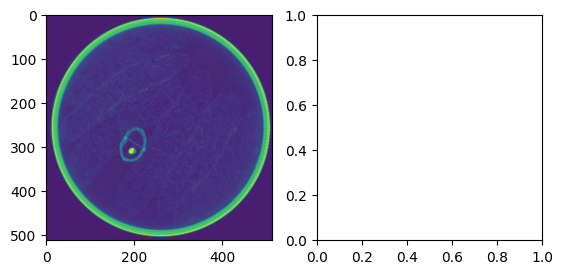

In [7]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img[img.shape[0]//2])
ax[1].imshow(mask[mask.shape[0]//2])

### Extract location information (bounding boxes and centroids) and 2D measurements for each labelled seed as pixelflow features table

In [8]:
features = pixelflow(
    mask,
    img,
    features=('label', 'bbox', 'centroid'),
    #custom=(custom_func,),
)

ValueError: Image must be YX or ZYX, check mask.ndim

In [ ]:
features

,label,volume,bbox_volume,sphericity,surface_area,convex_volume,area,area_bbox,area_convex,equivalent_diameter_area,euler_number,extent,feret_diameter_max,area_filled,axis_major_length,axis_minor_length,solidity
0,1,23985,47804,0.881878,4560.739258,25200,23985,47804,25200,35.780552,1,0.501736,40.062451,23985,38.780272,33.465873,0.951786
1,2,27412,53136,0.875586,5021.257812,28887,27412,53136,28887,37.409396,1,0.515884,43.324358,27412,41.252716,35.191819,0.948939
2,3,24333,46512,0.881111,4608.759766,25647,24333,46512,25647,35.952769,1,0.523155,39.166312,24333,37.789725,34.848344,0.948766
3,4,26423,53200,0.853651,5025.645996,27827,26423,53200,27827,36.953976,1,0.496673,42.391037,26423,40.411784,34.309909,0.949545
4,5,23113,46546,0.878744,4465.387207,24321,23113,46546,24321,35.341575,1,0.496563,39.648455,23113,37.985903,33.300995,0.950331
5,6,25121,47880,0.877822,4725.367676,26443,25121,47880,26443,36.336752,1,0.524666,39.509493,25121,37.618114,34.856945,0.950006
6,7,24786,46620,0.884700,4646.855469,26098,24786,46620,26098,36.174506,1,0.531660,38.755645,24786,37.040811,35.054150,0.949728
7,8,25734,47804,0.886344,4755.762207,27125,25734,47804,27125,36.629941,1,0.538323,40.112342,25734,38.761253,34.275752,0.948719
8,9,24574,47915,0.863853,4731.817383,25904,24574,47915,25904,36.071074,1,0.512867,39.749214,24574,37.614053,34.533586,0.948657
9,10,25794,49284,0.883744,4777.163086,27119,25794,49284,27119,36.658388,1,0.523375,40.570926,25794,38.604293,35.402736,0.951141


### Save and export features table as .CSV

In [ ]:
#output csv with measurements
features_csv = features.to_csv('01_Shengliyoucai_main_A.csv', header=True, index=False)